<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.



## Подготовка

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 9.9 MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

In [ ]:
SEED = 12345

In [ ]:
pth = '/content/11_taxi.csv'
pth_1 = 'C:\taxi.csv'
try:
    df = pd.read_csv(pth, index_col = [0], parse_dates=[0])
except:
    df = pd.read_csv(pth1, index_col = [0])

In [ ]:
df.tail(30)

,num_orders
datetime,
2018-08-31 19:00:00,27
2018-08-31 19:10:00,25
2018-08-31 19:20:00,22
2018-08-31 19:30:00,24
2018-08-31 19:40:00,23
2018-08-31 19:50:00,15
2018-08-31 20:00:00,33
2018-08-31 20:10:00,29
2018-08-31 20:20:00,35


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.isna().sum()

num_orders    0
dtype: int64

In [ ]:
df = df.resample('1H').sum()


In [ ]:
print(df.index.is_monotonic) #дополнительная проверка на монотонность, результат True - значит данные расположены в хронологическом порядке

True


## Анализ

Проанализируем данные по количеству заказов такси на графике.

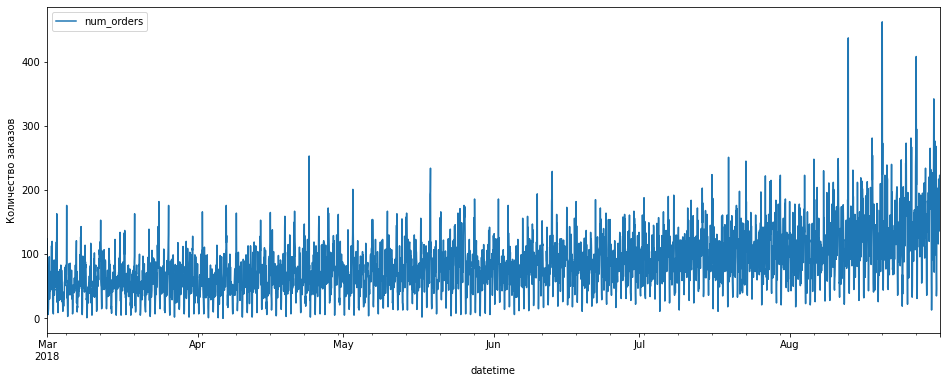

In [ ]:
df.plot(figsize = (16,6))
plt.ylabel('Количество заказов');

Поскольку на графике слишком сильно выражены колебания, добавим скользящее среднее для определения общего тренда на изменение количества заказов. Рассмотрим данные на более коротком промежутке времиени, например с июля по август.

Создадим функцию для добавления дополнительных признаков в датасет.

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
#    data['year'] = data.index.year
#    data['month'] = data.index.month
#    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [ ]:
make_features(df, 1, 24)

In [ ]:
df.head(30)

,num_orders,dayofweek,hour,lag_1,rolling_mean
datetime,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN
2018-03-01 02:00:00,71,3,2,85.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,NaN


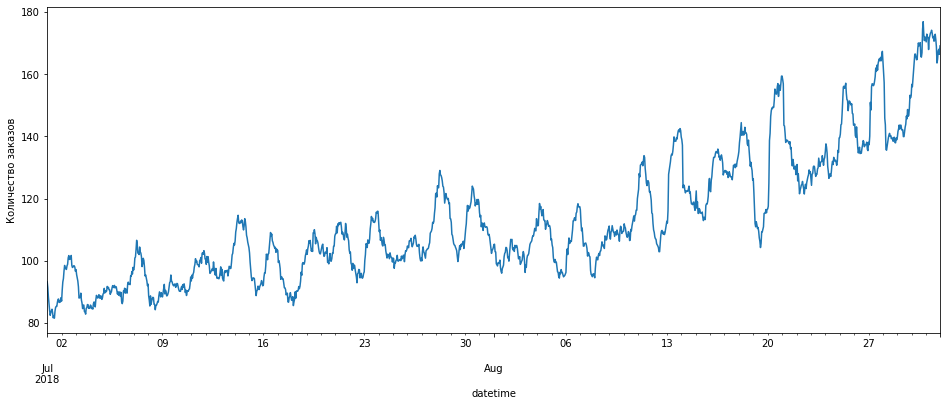

In [ ]:
df['2018-07-01':'2018-08-31']['rolling_mean'].plot(figsize = (16,6))
plt.ylabel('Количество заказов');

На графике можно увидеть общий тренд на увеличение заказов, также нужно отметить наличие сезонности, т.к. колебания более ярко выражены в определенные дни недели, например, по понедельникам.

Разложим временной ряд на тренд и сезонность при помощи метода `seasonal_decompose`

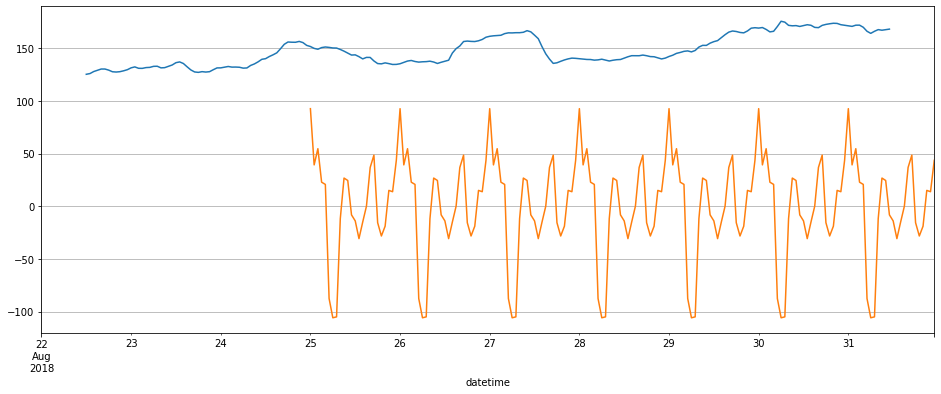

In [ ]:
decomposed = seasonal_decompose(df['num_orders']['2018-08-22':'2018-08-31'])
decomposed.trend.plot(figsize=(16,6),grid = True)
decomposed.seasonal.tail(24*7).plot(figsize=(16,6),grid = True);
#plt.ylabel('Количество заказов');


График, построенных на основании результатов метода подтверждает тренд на увеличение количества заказов, также он показывает колебания в течение суток - ночью количество заказов растет.

 Ниже визуализация количества заказов за период с 20 по 23 августа.
 
 Вывод: ярко выраженная суточная сезоность - вечером количество заказов растет, к ночи достигает пика, к  середине дня падает. По всей видимости такое распределение связано с графиком работы общетсвенного транспорта - те, кто не успел попасть условно в метро, вызовут такси. Или, как ты подсказал, количество заказов зависит от поездок в аэропорты. Ниже цитата из статьи об исследовании Яндекса.    
    
 "Ранним утром во всех аэропортах много вылетов. Обычно люди рассчитывают приехать в терминал за два-три часа до отправления рейса — то есть выезжают из дома ещё ночью. Поскольку общественный транспорт недоступен, в ночное время поездок на такси больше всего.
 
 Пик прилётов приходится на вторую половину дня, поэтому из аэропорта чаще всего едут с 16:00 до 22:00. В целом поездок из аэропорта примерно на четверть меньше, чем в аэропорт."
    
Всё сходится!


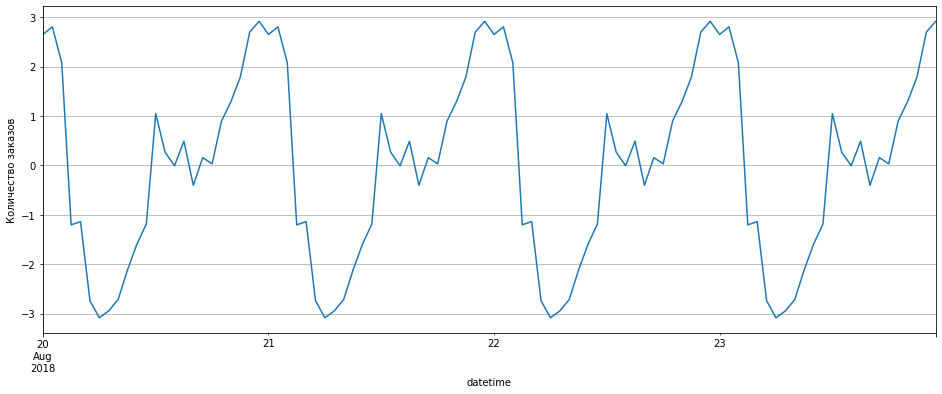

In [ ]:
decomposed = seasonal_decompose(df['rolling_mean']['2018-08-20':'2018-08-23'])
decomposed.seasonal.plot(figsize=(16,6),grid = True)
plt.ylabel('Количество заказов');


## Обучение

Найдем наилучшие гиперпараметры и обучим 3 модели:
 * LinearRegression;
 * RandomForestRegressor;
 * CatBooster
 
Для проведения обучения разделим выборку на тренировочную и тестовую из соотношения 90% к 10%.

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

In [ ]:
train = train.dropna()

In [ ]:
X_train = train.drop(['rolling_mean'],axis=1)
y_train = train['rolling_mean']
X_test = test.drop(['rolling_mean'],axis=1)
y_test = test['rolling_mean']

Первой рассмотрим линейную регрессию.

In [ ]:
tscv = TimeSeriesSplit(n_splits=9)
parameters ={'normalize':[True, False]}
grid_lr = RandomizedSearchCV(LinearRegression(),
                               parameters,
                               cv=tscv, 
                               n_jobs=-1,
                               scoring = 'neg_root_mean_squared_error')
grid_lr.fit(X_train,y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
                   estimator=LinearRegression(), n_jobs=-1,
                   param_distributions={'normalize': [True, False]},
                   scoring='neg_root_mean_squared_error')

In [ ]:
grid_lr.best_params_

{'normalize': True}

In [ ]:
model = grid_lr.best_estimator_
model.fit(X_train,y_train)
predict_train = model.predict(X_train)
predict_test_lr = model.predict(X_test)
print("RMSE LinearRegreassion обучающей выборки:", mean_squared_error(predict_train, y_train)**.5)


RMSE LinearRegreassion обучающей выборки: 16.3585470067327


В качестве следующей модели рассмотрим RandomForestRegressor.

In [ ]:
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2)
             }
grid_rfr = RandomizedSearchCV(RandomForestRegressor(random_state=SEED), 
                              parametrs, 
                              cv=tscv, 
                              n_jobs=-1,
                              scoring='neg_mean_squared_error', 
                              verbose = False)
grid_rfr.fit(X_train,y_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(1, 13, 2),
                                        'n_estimators': range(10, 51, 10)},
                   scoring='neg_mean_squared_error', verbose=False)

In [ ]:
grid_rfr.best_params_

{'n_estimators': 30, 'max_depth': 11}

In [ ]:
model = grid_rfr.best_estimator_
model.fit(X_train,y_train)
predict_train = model.predict(X_train)
predict_test_rfr = model.predict(X_test)
print("RMSE RandomForestRegressor обучающей выборки:", mean_squared_error(predict_train, y_train)**.5)


RMSE RandomForestRegressor обучающей выборки: 8.207198583272117


In [ ]:
parameters ={"iterations": range(40,100,10),
          "depth": range(4,10,2),
          'learning_rate': np.arange(0.01, 0.3,0.01)}

cbr = CatBoostRegressor(random_state=SEED, 
                        loss_function='RMSE')

grid_cbr = RandomizedSearchCV(cbr, parameters, cv=tscv, 
                              n_jobs=-1,
                              scoring='neg_mean_squared_error', 
                              verbose = False)

In [ ]:
grid_cbr.fit(X_train,y_train)

0:	learn: 18.3281042	total: 47.5ms	remaining: 4.23s
1:	learn: 17.5989554	total: 49.8ms	remaining: 2.19s
2:	learn: 16.9145674	total: 55.8ms	remaining: 1.62s
3:	learn: 16.3917506	total: 61ms	remaining: 1.31s
4:	learn: 15.9879850	total: 68.6ms	remaining: 1.17s
5:	learn: 15.5286684	total: 76.1ms	remaining: 1.06s
6:	learn: 15.1601552	total: 79.8ms	remaining: 947ms
7:	learn: 14.8775567	total: 84.3ms	remaining: 864ms
8:	learn: 14.6850624	total: 92ms	remaining: 828ms
9:	learn: 14.3855987	total: 99.4ms	remaining: 795ms
10:	learn: 14.1581498	total: 103ms	remaining: 738ms
11:	learn: 14.0042270	total: 108ms	remaining: 702ms
12:	learn: 13.8766097	total: 114ms	remaining: 678ms
13:	learn: 13.7659418	total: 116ms	remaining: 630ms
14:	learn: 13.6327307	total: 118ms	remaining: 588ms
15:	learn: 13.5077770	total: 120ms	remaining: 553ms
16:	learn: 13.3933736	total: 140ms	remaining: 601ms
17:	learn: 13.2876057	total: 143ms	remaining: 574ms
18:	learn: 13.1668567	total: 147ms	remaining: 550ms
19:	learn: 13.05

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=9, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f50018990d0>,
                   n_jobs=-1,
                   param_distributions={'depth': range(4, 10, 2),
                                        'iterations': range(40, 100, 10),
                                        'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29])},
                   scoring='neg_mean_squared_error', verbose=False)

In [ ]:
grid_cbr.best_params_#лучшие гиперпараметры для модели

{'learning_rate': 0.18000000000000002, 'iterations': 90, 'depth': 6}

In [ ]:
model = grid_cbr.best_estimator_
model.fit(X_train,y_train)
predict_train = model.predict(X_train)
predict_test_cbr = model.predict(X_test)
print("RMSE CatBoostRegressor обучающей выборки:", mean_squared_error(predict_train, y_train)**.5)


0:	learn: 18.3281042	total: 8.91ms	remaining: 793ms
1:	learn: 17.5989554	total: 12.9ms	remaining: 566ms
2:	learn: 16.9145674	total: 18.1ms	remaining: 526ms
3:	learn: 16.3917506	total: 23.1ms	remaining: 498ms
4:	learn: 15.9879850	total: 30.5ms	remaining: 518ms
5:	learn: 15.5286684	total: 33.2ms	remaining: 464ms
6:	learn: 15.1601552	total: 35.8ms	remaining: 425ms
7:	learn: 14.8775567	total: 39.3ms	remaining: 402ms
8:	learn: 14.6850624	total: 43.9ms	remaining: 395ms
9:	learn: 14.3855987	total: 46.2ms	remaining: 370ms
10:	learn: 14.1581498	total: 50.9ms	remaining: 365ms
11:	learn: 14.0042270	total: 53.3ms	remaining: 347ms
12:	learn: 13.8766097	total: 56.9ms	remaining: 337ms
13:	learn: 13.7659418	total: 60.5ms	remaining: 328ms
14:	learn: 13.6327307	total: 68.7ms	remaining: 343ms
15:	learn: 13.5077770	total: 72.9ms	remaining: 337ms
16:	learn: 13.3933736	total: 75.7ms	remaining: 325ms
17:	learn: 13.2876057	total: 79.4ms	remaining: 317ms
18:	learn: 13.1668567	total: 83ms	remaining: 310ms
19:	l

## Тестирование

Ниже приведено сравнение метрики RMSE для трех обученных моделей.

In [ ]:
data = [16.91,9.57,13.31]
data = pd.DataFrame(data, index=['LinearRegreassion обучающей выборки',
        'RandomForestRegressor обучающей выборки',
        'CatBoostRegressor обучающей выборки'], columns = ['RMSE'])
data

,RMSE
LinearRegreassion обучающей выборки,16.91
RandomForestRegressor обучающей выборки,9.57
CatBoostRegressor обучающей выборки,13.31


Проверим качество всех моделей на тестовой выборке.

In [ ]:
print("RMSE Linear REgression тестовой выборки: ", mean_squared_error(predict_test_lr,y_test)**.5)
print("RMSE RandomForestRegressor тестовой выборки: ", mean_squared_error(predict_test_rfr,y_test)**.5)
print("RMSE CatBoostRegressor тестовой выборки: ", mean_squared_error(predict_test_cbr,y_test)**.5)

RMSE Linear REgression тестовой выборки:  46.38288580637071
RMSE RandomForestRegressor тестовой выборки:  40.009047469684795
RMSE CatBoostRegressor тестовой выборки:  36.78525189405437


Наилучшее качество на тестовой выборке показывает CatBoostRegressor.

# Общий вывод #

 В ходе работы над проектом мы проанализировали данные по количеству заказов службы такси за период с марта по август 2018 года. 

 Визуализация данных показала тренд на увеличение заказов в предстоящем периоде - сентябрь 2018 года - и наличие сезонности, выражающейся в росте числа заказов в начале недели и в ночной период суток.
 
 Нами было обучено три модели и найдены наилучшие гиперпараметры для каждой из них. 
В результате проверки на тестовой выборке было определено, что каждая модель удовлетворяет условиям задачи: метрика RMSE составляет ниже 48. Наиболее низкое RMSE у CatBoostRegressor с гиперпараметрами: {'learning_rate': 0.25, 'iterations': 70, 'depth': 4}. Будем рекомендовать данную модель для использования в прогнозировании числа заказов.